In [1]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gc
from torchvision.models import resnet50
from torchvision.transforms import v2
from PIL import Image
from itertools import groupby
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
from torch.optim.lr_scheduler import CosineAnnealingLR
# from medcam import medcam

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")
os.chdir('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [4]:
label_index = {
    'bipolar dissector': 0,
    'bipolar forceps': 1,
    'cadiere forceps': 2,
    'clip applier ': 3,
    'force bipolar': 4,
    'grasping retractor': 5,
    'monopolar curved scissors': 6,
    'needle driver': 7,
    'needle driver2': 8,
    'permanent cautery hook/spatula': 9,
    'prograsp forceps': 10,
    'stapler': 11,
    'suction irrigator': 12,
    'tip-up fenestrated grasper': 13,
    'vessel sealer': 14
}
data = pd.read_csv('labels.csv')
label_onehot = np.zeros((data.shape[0], 15))
for index in range(data.shape[0]):
    tools = data['tools_present'][index][1:-1].replace('nan, ', '').split(', ')
    label_onehot[index][8] = 1 if tools.count('needle driver') > 1 else 0
    for j in range(3):
        label_onehot[index][label_index[tools[j]]] = 1

In [5]:
print(label_onehot)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [6]:
os.chdir('/content/gdrive/MyDrive/robot_tool_data')
def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if '.jpg' in file:
                file_paths.append(os.path.join(root, file))
    file_paths.sort(key=str.lower)
    return file_paths

class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Assuming each image filename contains a list of class labels
        self.image_paths = get_file_paths(self.root_dir)  # List of image file paths
        self.labels = label_onehot       # List of lists, each containing multiple class labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.FloatTensor(self.labels[idx])

        return image, label


In [7]:
def top_n_accuracy(scores, targets, n=3):
    _, predictions = scores.topk(n, 1, True, True)
    _, targets = targets.max(dim=1)
    correct_predictions = predictions.eq(targets.view(-1, 1).expand_as(predictions))
    accuracy = correct_predictions.sum().item() / targets.size(0)
    return accuracy

In [8]:

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=45)], p=0.5),  # Add rotation
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.5),  # Add random resized crop
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = MultiLabelDataset(root_dir='.', transform=transform)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to create datasets for training, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_resnet = resnet50(weights=None)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 15)
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-5)
model_save_name = 'model_resnet4.pt'
path = f"/content/gdrive/MyDrive/{model_save_name}"
PATH = "/content/gdrive/MyDrive/model_resnet_chkpt4"


initial_lr = 1e-5
min_lr = 1e-7
max_lr = 0.1
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=min_lr)
training_loss_history = []
val_loss_history = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)
# Training loop
for epoch in range(num_epochs):
    model_resnet.train()
    torch.save(model_resnet.state_dict(), path)

    total_loss = 0.0
    for batch in train_dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        del inputs, targets, outputs
        gc.collect()
        torch.cuda.empty_cache()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    training_loss_history.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        total_val_loss = 0
        for batch_idx, (data,targets) in enumerate(val_dataloader):
            data = data.to(device)
            targets = targets.to(device)
            scores = model_resnet(data)
            val_loss = criterion(scores, targets)
            total_val_loss += val_loss.item()
        average_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(average_val_loss)
        print(f"Validation Loss: {average_val_loss}")
    scheduler.step()
    torch.save({
            'epoch': epoch,
            'model_state_dict': model_resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_loss,
            }, PATH)

Epoch [1/30], Loss: 7.0360
Validation Loss: 6.196329832077026
Epoch [2/30], Loss: 5.8480
Validation Loss: 5.698660516738892
Epoch [3/30], Loss: 5.5778
Validation Loss: 5.5439403533935545
Epoch [4/30], Loss: 5.4764
Validation Loss: 5.42460265159607
Epoch [5/30], Loss: 5.4071
Validation Loss: 5.34745044708252
Epoch [6/30], Loss: 5.3300
Validation Loss: 5.302687072753907
Epoch [7/30], Loss: 5.2943
Validation Loss: 5.292499685287476
Epoch [8/30], Loss: 5.2466
Validation Loss: 5.24178638458252
Epoch [9/30], Loss: 5.2376
Validation Loss: 5.162533950805664
Epoch [10/30], Loss: 5.2123
Validation Loss: 5.243213081359864
Epoch [11/30], Loss: 5.1961
Validation Loss: 5.160744619369507
Epoch [12/30], Loss: 5.1144
Validation Loss: 5.154079294204712
Epoch [13/30], Loss: 5.1263
Validation Loss: 5.051166963577271
Epoch [14/30], Loss: 5.1376
Validation Loss: 5.0526995182037355
Epoch [15/30], Loss: 5.1361
Validation Loss: 5.100910568237305
Epoch [16/30], Loss: 5.0761
Validation Loss: 5.088247680664063
Ep

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
#model_resnet = medcam.inject(model_resnet, output_dir="attention_maps", save_maps=True)
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    total_accuracy = 0
    for batch_idx, (data,targets) in enumerate(test_dataloader):
        data = data.to(device)
        targets = targets.to(device)
        scores = model_resnet(data)
        batch_accuracy = top_n_accuracy(scores, targets, n=3)
        total_accuracy += batch_accuracy
    average_accuracy = total_accuracy / len(test_dataloader)
    print(f"Accuracy : {average_accuracy * 100:.2f}%")

Accuracy : 96.67%


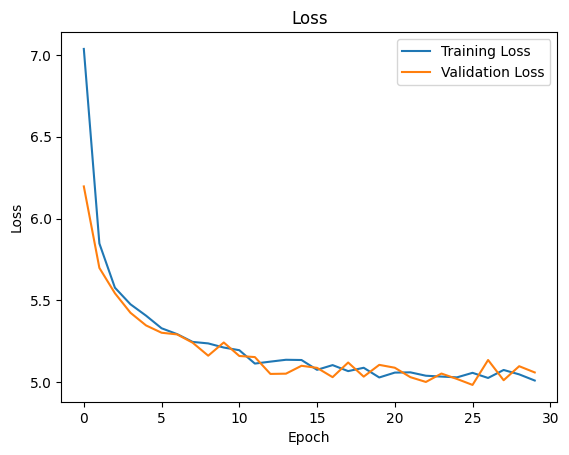

In [10]:
plt.plot(training_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
model_save_name = 'model_resnet3.pt'
model_resnet = resnet50(weights=None)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 15)
path = f"/content/gdrive/MyDrive/{model_save_name}"
model_resnet.load_state_dict(torch.load(path))

<All keys matched successfully>

<ipython-input-12-5016a9426e71>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


torch.return_types.topk(
values=tensor([0.2950, 0.2052, 0.2014], device='cuda:0'),
indices=tensor([2, 1, 6], device='cuda:0'))


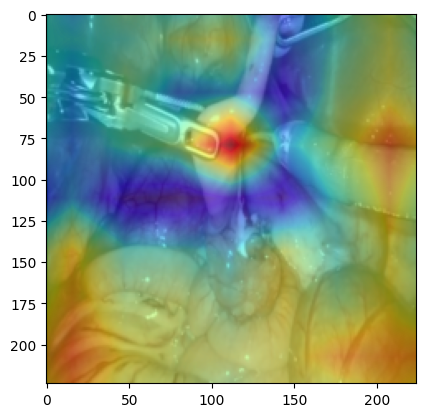

In [12]:
from torch import topk
from torchvision import transforms
import skimage
model = model_resnet
model.to(device)
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])
image = Image.open('clip_000033.jpg').convert('RGB')
display_transform = transforms.Compose([
   transforms.Resize((224,224))])
tensor = preprocess(image)
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)
prediction_var.to(device)
model.to(device)
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)
prediction = model(prediction_var.to(device))
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
class_idx = topk(pred_probabilities,1)[1].int()
print(topk(pred_probabilities,3))
overlay = getCAM(activated_features.features, weight_softmax, class_idx )
plt.imshow(overlay[0], alpha=0.5, cmap='jet')
plt.imshow(display_transform(image))
plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');


torch.return_types.topk(
values=tensor([2.6678, 2.3281, 2.2969, 1.6597, 1.5903], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([2, 6, 1, 7, 8], device='cuda:0'))


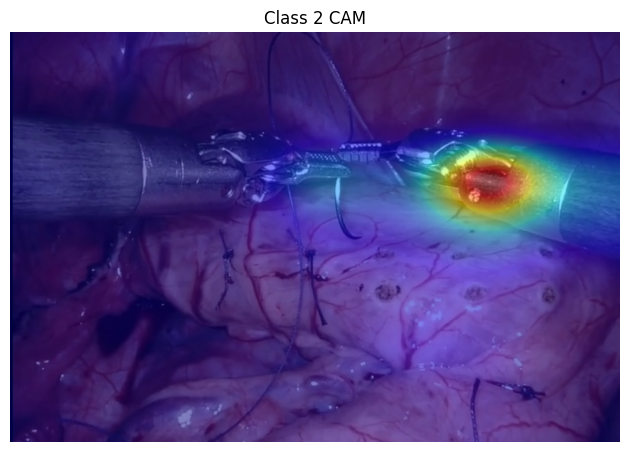

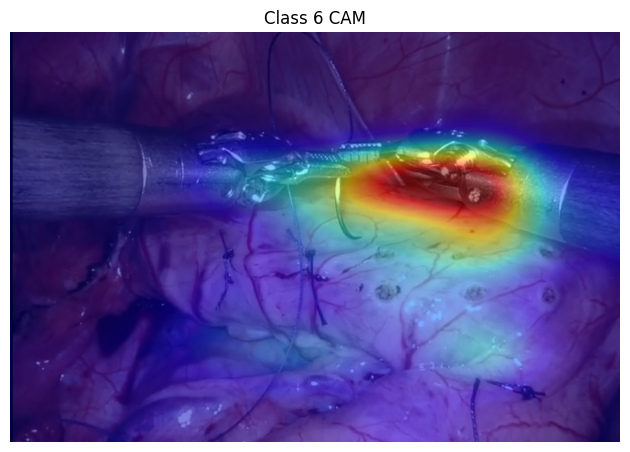

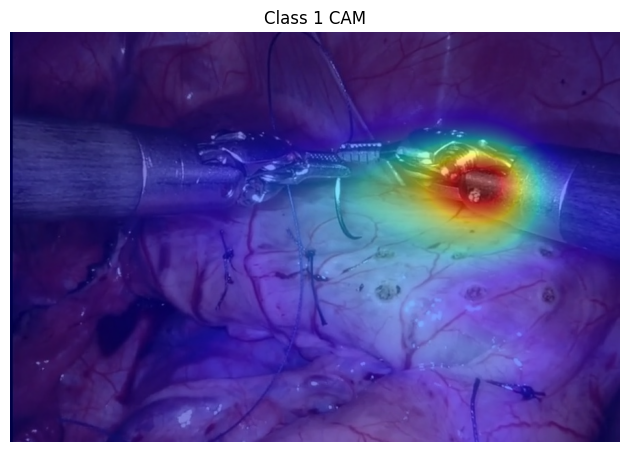

In [18]:
from torchcam.methods import SmoothGradCAMpp
#cam_extractor = SmoothGradCAMpp(model_resnet)
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet50
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

model = model_resnet#resnet50(pretrained=True).eval()
# Get your input
img = read_image("clip_000098.jpg")
# Preprocess it for your chosen model

input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
with SmoothGradCAMpp(model, target_layer='layer4') as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0).to(device))

    # Get the top three predicted classes and their scores
    top_classes = out.squeeze(0).topk(3).indices
    print(out.squeeze(0).topk(5))

    for class_index in top_classes:
        # Retrieve the CAM for the current class
        #model.zero_grad()
        activation_map = cam_extractor(class_index.item(), out)

        # Overlay the CAM on the input image
        result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

        # Display the result for each class
        plt.imshow(result)
        plt.title(f"Class {class_index.item()} CAM")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [13]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.2 MB/s eta 0:00:00
